TokaMaker Example: Simple H-mode scenario with boostrap in ITER {#doc_tMaker_ITER_ex3}
==========
In this example we show how to compute equilibria in ITER with H-mode like profiles for the "inverse" case where we have a desired shape, plasma current and pressure, but the required coil currents are unkown.

This example utilizes the mesh built in \ref doc_tMaker_ITER_ex1.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python packages. Both of which are installable using `pip` or other standard methods. This example also requires use of the Sauter formula for bootstrap current (See: O. Sauter, et al., Phys. Plasmas 6, 2834 (1999); [DOI:10.1063/1.873240](https://doi.org/10.1063/1.873240)). It is available as part of the open source platform OMFIT, written as part of the Kolemen Group Automatic Kinetic EFIT Project "auto_kEFIT" (See: https://omfit.io/_modules/omfit_classes/utils_fusion.html).

This formula can be installed using pip:
`$ pip install --upgrade omfit_classes`

The utility function `Hmode_profiles()` is also imported from `omfit_classes` to facilitate specification of a pressure pedestal.

In [1]:
import os
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from omfit_classes.utils_fusion import sauter_bootstrap, Hmode_profiles

plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')

if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, create_power_flux_fun
# from OpenFUSIONToolkit.TokaMaker.bootstrap import solve_with_bootstrap

## Compute equilibria

### Initialize TokaMaker object
We now create a \ref OpenFUSIONToolkit.OFT_env "OFT_env" instance for execution using two threads and a \ref OpenFUSIONToolkit.TokaMaker.TokaMaker "TokaMaker" instance to use for equilibrium calculations. Note at present only a single `TokaMaker` instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
myOFT = OFT_env(nthreads=2)
mygs = TokaMaker(myOFT)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:    main
Revision id:           51e08bd
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = /var/folders/9p/90ydvncx0zb8sqr976fmrfxr0000gn/T/oft_37863/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the mesh generated in \ref doc_tMaker_ITER_ex1 using \ref OpenFUSIONToolkit.TokaMaker.load_gs_mesh "load_gs_mesh()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh". Then we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions()", passing the conductor and coil dictionaries for the mesh, to define the different region types. Finally, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup()" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('ITER_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.settings.maxits=100
mygs.setup(order = 2, F0 = 5.3*6.2)


**** Loading OFT surface mesh

**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.859E+02
    # of points  =    4757
    # of edges   =   14156
    # of cells   =    9400
    # of boundary points =     112
    # of boundary edges  =     112
    # of boundary cells  =     112
  Resolution statistics:
    hmin =  9.924E-03
    hrms =  2.826E-01
    hmax =  8.466E-01
  Surface grounded at vertex     870


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    6.5899999999999997E-004


### Define a vertical stability coil
Like many elongated equilibria, the equilibrium we seek to compute below is vertically unstable. In this case we use the actual ITER Vertical Stability Coil (VSC) in order to help with convergence using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_vsc "set_coil_vsc()" method.

**Note:** While ITER has a "real" VSC, this is not required and this functionality can instead be used to define a "virtual" VSC by pairing coils in a way that are not necessarily paired experimentally.

In [5]:
mygs.set_coil_vsc({'VS': 1.0})

### Define hard limits on coil currents
Hard limits on coil currents can be set using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_bounds "set_coil_bounds()". In this case we just the simple and approximate bi-directional limit of 50 MA in each coil.

Bounds are specified using a dictionary of 2 element lists, containing the minimum and maximum bound, where the dictionary key corresponds to the coil names, which are available in \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.coil_sets "mygs.coil_sets"

In [6]:
coil_bounds = {key: [-50.E6, 50.E6] for key in mygs.coil_sets}
mygs.set_coil_bounds(coil_bounds)

## Compute Inverse Equilibrium

### Define global quantities and targets
For the inverse case we define a target for the plasma current and the peak plasma pressure, which occurs on the magnetic axis.

**Note:** These constraints can be considered "hard" constraints, where they will be matched to good tolerance as long as the calculation converges.

In [7]:
Ip_target=13.0E6
P0_target=6.2E5
mygs.set_targets(Ip=Ip_target, pax=P0_target)

### Define shape targets
In order to constrain the shape of the plasma we can utilize two types of constraints:
 1. `isoflux` points, which are points we want to lie on the same flux surface (eg. the LCFS)
 2. `saddle` points, where we want the poloidal magnetic field to vanish (eg. X-points). While one can also use this constraint to enforce a magnetic axis location, instead \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_targets "set_targets()" should be used with arguments `R0` and `V0`.

**Note:** These constraints can be considered "soft" constraints, where the calculation attempts to minimize error in satisfying these constraints subject to other constraints and regularization.

Here we define a handful of isoflux points that we want to lie on the LCFS of the target equilibrium. Additionally, we define a single X-point and set it as a saddle constraint as well as adding it to the list of isoflux points.

In [8]:
isoflux_pts = np.array([
    [ 8.20,  0.41],
    [ 8.06,  1.46],
    [ 7.51,  2.62],
    [ 6.14,  3.78],
    [ 4.51,  3.02],
    [ 4.26,  1.33],
    [ 4.28,  0.08],
    [ 4.49, -1.34],
    [ 7.28, -1.89],
    [ 8.00, -0.68]
])
x_point = np.array([[5.125, -3.4],])
mygs.set_isoflux(np.vstack((isoflux_pts,x_point)))
mygs.set_saddles(x_point)

### Define coil regularization matrix
In general, for a given coil set a given plasma shape cannot be exactly reproduced, which generally yields large amplitude coil currents if no constraint on the coil currents is applied. As a result, it is useful to include regularization terms for the coils to balance minimization of the shape error with the amplitude of current in the coils. In TokaMaker these regularization terms have the general form, where each term corresponds to a set of coil coefficients, target value, and weight. The \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.coil_reg_term "coil_reg_term()" method is provided to aid in defining these terms.

In this case, one regularization term is added for each coil with a single unit coefficient for that coil and target of zero with modest weights. This regularization acts to penalize the amplitude of current in each coil, acting to balance coil current with error in the shape targets. Note that the weight on the VSC virtual coil (`#VSC`) defined above is set high to prevent interaction with the real `VS` coil set (see below for further information).

In [9]:
# Set regularization weights
regularization_terms = []
for name, coil in mygs.coil_sets.items():
    # Set zero target current and different small weights to help conditioning of fit
    if name.startswith('CS'):
        if name.startswith('CS1'):
            regularization_terms.append(mygs.coil_reg_term({name: 1.0},target=0.0,weight=2.E-2))
        else:
            regularization_terms.append(mygs.coil_reg_term({name: 1.0},target=0.0,weight=1.E-2))
    elif name.startswith('PF'):
        regularization_terms.append(mygs.coil_reg_term({name: 1.0},target=0.0,weight=1.E-2))
    elif name.startswith('VS'):
        regularization_terms.append(mygs.coil_reg_term({name: 1.0},target=0.0,weight=1.E-2))
# Disable VSC virtual coil
regularization_terms.append(mygs.coil_reg_term({'#VSC': 1.0},target=0.0,weight=1.E2))

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(reg_terms=regularization_terms)

### Define flux functions
Although TokaMaker has a "default" profile for the F\*F' and P' terms this should almost never be used and one should instead choose an appropriate flux function for their application. In this case we use an H-mode-like kinetic profiles parametrized via the OMFIT function `Hmode_profiles()` (see note at top). Within TokaMaker these profiles are represented as piecewise linear functions, which can be set up using the dictionary approach shown below.

Using the OMFIT `Hmode_profiles()` profile parametrization function, we can specify ITER-like H-mode profiles. See Figs. 18 and 19 for these $n_e$ and $T_e$ profiles: https://iopscience.iop.org/article/10.1088/0029-5515/48/7/075005/pdf

For pressure, we are assuming a quasineutral and isothermal plasma, (i.e. ne = ni, Te = Ti), however this assumption is not usually valid in the core and separate ion profiles will need to be specified. 

**Note:** More tools to aide in setting these profiles are coming soon

In [10]:
n_sample = 257
psi_sample = np.linspace(0.0,1.0,n_sample)

### Define ne and Te profiles
xphalf = 0.965
widthp_Te = 0.1
widthp_ne = 0.35

ne = Hmode_profiles(edge=0.35, ped=0.6, core=1.1, rgrid=n_sample, expin=1.6, expout=1.6, widthp=widthp_ne, xphalf=xphalf) * 1e20
Te = Hmode_profiles(edge=1500., ped=5000., core=21000., rgrid=n_sample, expin=1.3, expout=1.7, widthp=widthp_Te, xphalf=xphalf)
ni = ne.copy() # Assuming quasineutrality
Ti = Te.copy() # Assuming isothermal
pressure = (1.602e-19 * ne * Te) + (1.602e-19 * ni * Ti) # 1.602e-19 * [m^-3] * [eV] = [Pa]

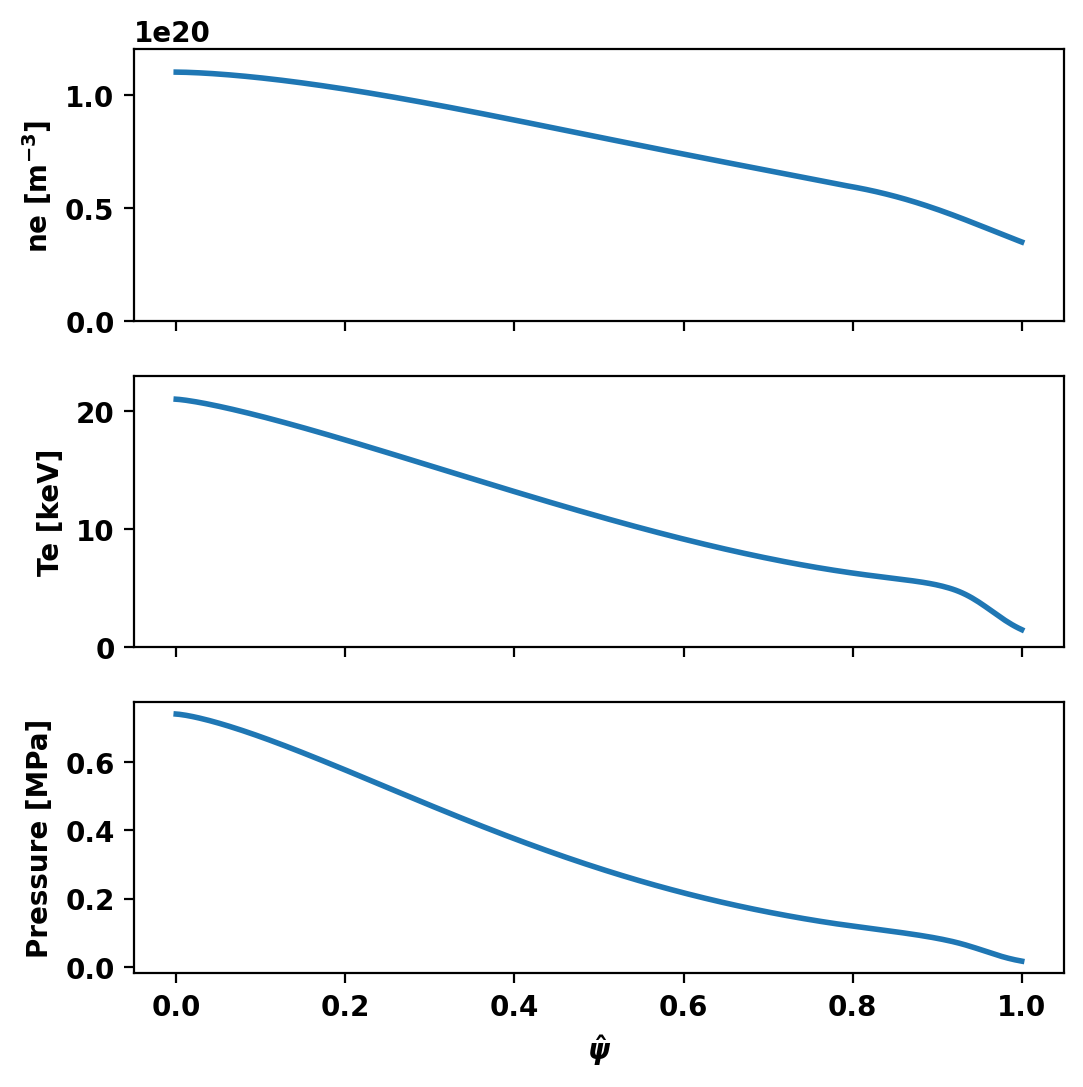

In [11]:
fig, ax = plt.subplots(3,1,sharex=True)
# Plot ne
ax[0].plot(psi_sample,ne)
ax[0].set_ylabel(r'ne [m$^{-3}$]')
ax[0].set_ylim(0.,1.2e+20)
# Plot Te
ax[1].plot(psi_sample,Te/1e3)
ax[1].set_ylabel("Te [keV]")
ax[1].set_ylim(0.,23)
# Plot total pressure
ax[2].plot(psi_sample,pressure/1e6)
ax[2].set_ylabel("Pressure [MPa]")
ax[-1].set_xlabel(r"$\hat{\psi}$")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

Using the OMFIT `Hmode_profiles()` profile parametrization function, we can specify an inductive, L-mode-like $j_{\phi}$ profile. See Fig. 7 for a reference $j_{total}$ profile including the bootstrap contribution: https://iopscience.iop.org/article/10.1088/0029-5515/48/7/075005/pdf

This $j_{inductive}$ profile was generated by hand such that the sum of $j_{inductive}$ and the boostrap current profile ($j_{bootstrap}$) calculated by the Sauter formula approximately equal the high fidelity $j_{total}$ profile in Fig. 7. Achieving this may require referencing a published $j_{total}$ profile which was calculated via transport simulations in similar conditions to your goal TokaMaker equilibrium, some iteration by hand, or a combination of the two.

In [12]:
### Set up initial inductive J_phi profile
jphi_prof = create_power_flux_fun(len(psi_sample),2.25,2.5)

inductive_jphi = jphi_prof['y']

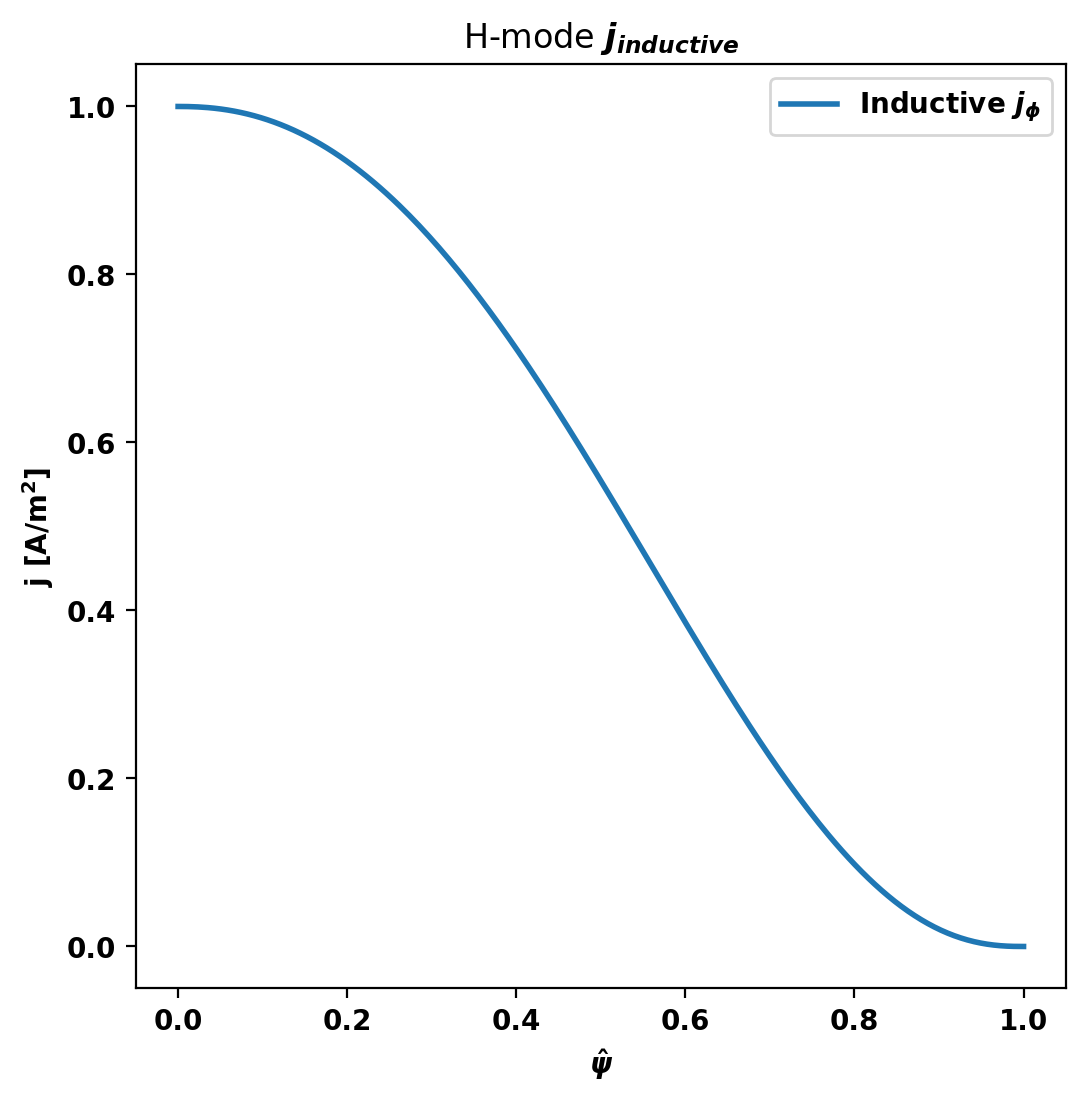

In [13]:
fig, ax = plt.subplots(1,1,sharex=True)
# Plot j_inductive
ax.plot(psi_sample,inductive_jphi,label='Inductive $j_{\phi}$')
ax.set_ylabel("j [A/m$^2$]")
ax.set_xlabel(r"$\hat{\psi}$")
ax.set_title("H-mode $j_{inductive}$")
_ = ax.legend()

### Compute equilibrium
We can now compute a free-boundary equilibrium using these constraints. Note that before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.init_psi "init_psi()". This subroutine initializes the flux using the specified Ip_target from above, which is evenly distributed over the entire plasma region or only with a boundary defined using a center point (R,Z), minor radius (a), and elongation and triangularity. Coil currents are also initialized at this point using the constraints above and this uniform plasma current initialization. 

\ref OpenFUSIONToolkit.TokaMaker.TokaMaker.solve "solve()" is then called to compute a self-consitent Grad-Shafranov equilibrium. If the result variable (`err_flag`) is zero then the solution has converged to the desired tolerance ($10^{-6}$ by default).

In [14]:
R0 = 6.3
Z0 = 0.5
a = 2.0
kappa = 1.4
delta = 0.0
err_flag = mygs.init_psi(R0, Z0, a, kappa, delta)
err_flag = mygs.solve()

Starting non-linear GS solver
     1  2.0057E+00  7.4856E-02  1.6900E-01  6.4429E+00  5.2060E-01  1.2001E-03
     2  2.8259E+00  6.6258E-02  4.9972E-02  6.4389E+00  5.2329E-01  8.9350E-04
     3  2.9925E+00  6.4556E-02  1.6311E-02  6.4343E+00  5.2488E-01  7.9526E-04
     4  3.0295E+00  6.4185E-02  5.6844E-03  6.4319E+00  5.2570E-01  7.6255E-04
     5  3.0377E+00  6.4104E-02  2.0474E-03  6.4309E+00  5.2609E-01  7.5149E-04
     6  3.0395E+00  6.4087E-02  7.4574E-04  6.4305E+00  5.2627E-01  7.4772E-04
     7  3.0398E+00  6.4084E-02  2.7162E-04  6.4303E+00  5.2635E-01  7.4644E-04
     8  3.0399E+00  6.4084E-02  9.8375E-05  6.4303E+00  5.2639E-01  7.4600E-04
     9  3.0399E+00  6.4084E-02  3.5317E-05  6.4303E+00  5.2641E-01  7.4585E-04
    10  3.0399E+00  6.4084E-02  1.2546E-05  6.4303E+00  5.2641E-01  7.4580E-04
    11  3.0399E+00  6.4084E-02  4.4088E-06  6.4303E+00  5.2642E-01  7.4578E-04
    12  3.0399E+00  6.4084E-02  1.5360E-06  6.4303E+00  5.2642E-01  7.4577E-04
    13  3.0399E+00  6.

### Now input kinetic profiles to obtain H-mode solution

\ref OpenFUSIONToolkit.TokaMaker.solve_with_bootstrap "solve_with_bootstrap()" is now called to compute a self-consistent Grad-Shafranov equilibrium that includes non-inductive current (the bootstrap current). Inclusion of bootstrap current effects is essential for H-mode equilibrium stability. If the result variable (`err_flag`) is zero then the solution has converged to the desired tolerance ($10^{-6}$ by default).

In [15]:
Zeff=np.linspace(1.5,1.5,n_sample)
ni = ne.copy()
Ti = Te.copy()

mygs.settings.pm=False
mygs.update_settings()

# results = solve_with_bootstrap(mygs,
#                                ne,
#                                Te,
#                                ni,
#                                Ti,
#                                Zeff,
#                                Ip_target,
#                                inductive_jphi,
#                                scale_jBS=1.0,
#                                isolate_edge_jBS=False,
#                                diagnostic_plots=False
#                               )

### Plot equilibrium
Flux surfaces of the computed equilibrium can be plotted using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_psi "plot_psi()" method. The additional plotting methods \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_machine "plot_machine()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_constraints "plot_constraints()" are also used to show context and other information. Each method has a large number of optional arguments for formatting and other options.

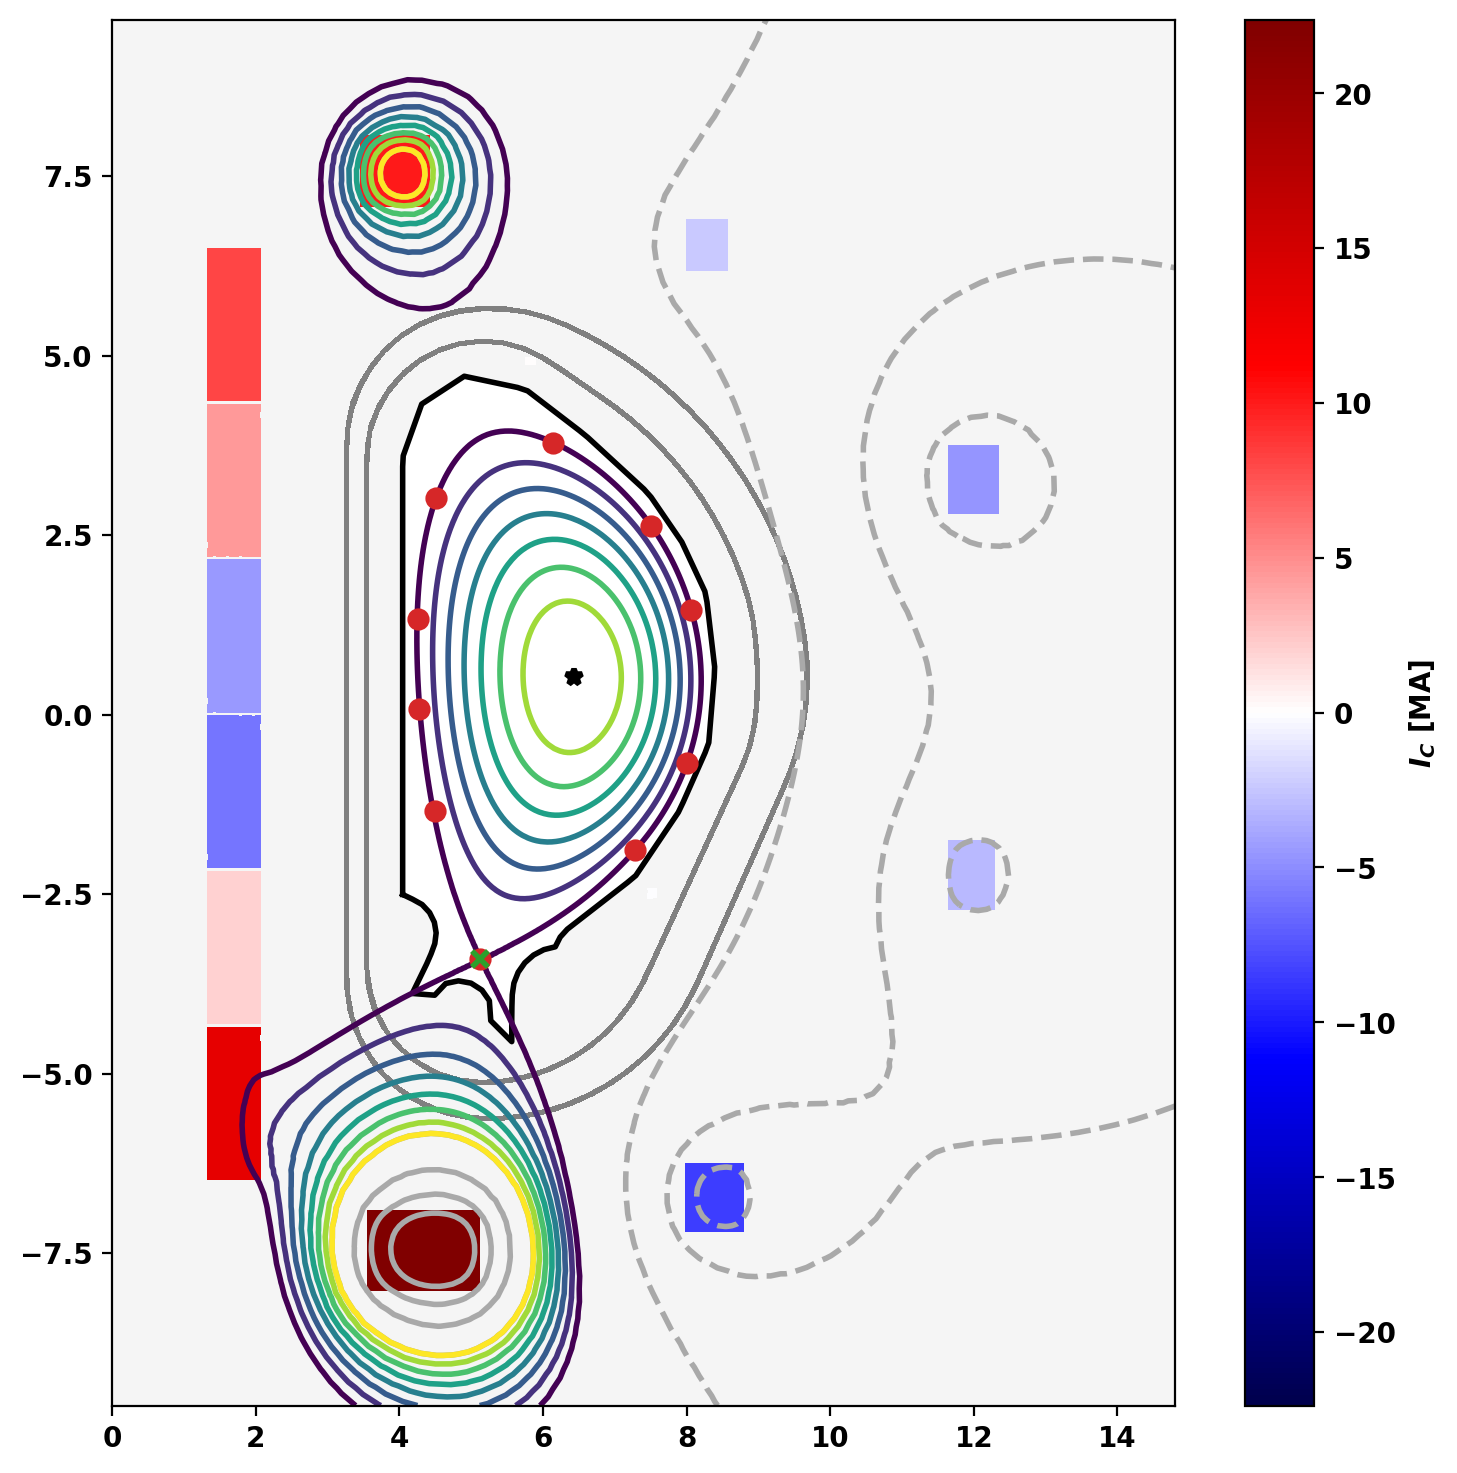

In [16]:
fig, ax = plt.subplots(1,1,figsize=(9,9))
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
mygs.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='o')

### Plot final self-consistent equilibrium profiles, including $j_{bootstrap}$ contribution

In [17]:
psi,f,fp,p,pp = mygs.get_profiles(npsi=257,psi_pad=1e-3)
_, q, ravgs, _, _, _ = mygs.get_q(npsi=257,psi_pad=1e-3) # get flux averaged R and 1/R from equilibrium solution

# Retrieve desired j_phi profile components
# final_jphi = results['total_j_phi']
# final_j_inductive = results['j_inductive']
# j_BS = results['j_BS']

In [18]:
# fig,axs = plt.subplots(4,2,figsize=(10.,10.5))
# axs[0,0].plot(psi,pp)
# axs[0,0].set_ylabel("P'")

# axs[0,1].plot(psi,p/1e+06)
# axs[0,1].set_ylabel("P [MPa]")

# axs[1,0].plot(psi,f)
# axs[1,0].set_ylabel("F")

# axs[1,1].plot(psi,f*fp)
# axs[1,1].set_ylabel("FF'")

# axs[2,0].plot(psi,q)
# axs[2,0].set_ylabel("q")
# axs[2,0].axhline(1.0,ls='--',c='k')

# axs[2,1].plot(psi,final_jphi/1e+06)
# axs[2,1].plot(psi,final_j_inductive/1e+06,ls='--',label='j$_{ohmic}$')
# axs[2,1].plot(psi,j_BS/1e+06,label='j$_{bs}$')
# axs[2,1].legend()
# axs[2,1].set_ylabel("j$_{\phi}$ [MA/m$^2$]")

# axs[3,0].plot(psi,j_BS/1e+06)
# axs[3,0].set_xlabel('$\psi_N$')
# axs[3,0].set_ylabel("j$_{bs}$ [MA/m$^2$]")

# axs[3,1].plot(psi,final_j_inductive/1e+06)
# axs[3,1].set_xlabel('$\psi_N$')
# axs[3,1].set_ylabel("j$_{ohmic}$ [MA/m$^2$]")

### Zoom in on final $j_{total}$ = $j_{inductive}$ + $j_{bootstrap}$

In [19]:
# fig, axs = plt.subplots(2,1,figsize=(6,8),sharex=True)
# _,q,_,_,_,_ = mygs.get_q(npsi=n_sample)

# # Plot j_total
# axs[0].plot(psi,final_jphi/1e+6,label='Output $j_{\phi}$') # in MA/m^2
# # Plot j_ohmic
# axs[0].plot(psi,final_j_inductive/1e+06,ls='--',label='j$_{ohmic}$') # in MA/m^2
# # Plot j_bootstrap
# axs[0].plot(psi,j_BS/1e+6,ls='--',label='$j_{bootstrap}$') # in MA/m^2

# axs[0].set_ylabel("j [MA/m$^2$]")
# axs[0].set_title("H-mode $j_{\phi}$")
# _ = axs[0].legend()
# axs[0].grid(ls=':')

# axs[1].plot(psi,q,label='Safety factor') # in MA/m^2
# axs[1].set_xlabel(r"$\hat{\psi}$")
# axs[1].set_ylabel(r"Safety Factor")
# axs[1].grid(ls=':')

### Compute equilibrium with parameterized core current profile to set q-on-axis
There is a subtle reverse shear region visiible in the core j$_\phi$ and safety factor profiles, which is resulting from the sum of our inductive profile and the Sauter calculated j$_{bootstrap}$ profile together providing an excess of current. We can adjust the core j$_\phi$ (and therefore safety factor) profile to our desired shape by setting `isolate_edge_jBS=True` in our "solve_with_bootstrap()" call. Now, the edge bootstrap spike will be retained from the Sauter prediction, but the core j$_\phi$ profile inside the edge j$_{bootstrap}$ spike will simply be our specified inductive_jphi.

In [20]:
# start_time = time.perf_counter()

# results = solve_with_bootstrap(mygs,
#                                ne,
#                                Te,
#                                ni,
#                                Ti,
#                                Zeff,
#                                Ip_target,
#                                inductive_jphi,
#                                scale_jBS=1.0,
#                                isolate_edge_jBS=True,
#                                diagnostic_plots=True
#                               )

# end_time = time.perf_counter()

In [21]:
# elapsed_time = end_time - start_time
# print(f"Function 'solve_with_bootstrap' took {elapsed_time:.4f} seconds to execute.")

In [22]:
# fig, axs = plt.subplots(2,1,figsize=(6,8),sharex=True)

# _,q,_,_,_,_ = mygs.get_q(npsi=n_sample)

# # Plot j_total
# axs[0].plot(psi,results['total_j_phi']/1e+6,label='Output $j_{\phi}$') # in MA/m^2
# # Plot j_ohmic
# axs[0].plot(psi,results['j_inductive']/1e+06,ls='--',label='j$_{ohmic}$') # in MA/m^2
# # Plot j_bootstrap
# axs[0].plot(psi,results['isolated_j_BS']/1e+6,ls='--',label='Isolated edge $j_{bootstrap}$') # in MA/m^2

# axs[0].set_ylabel("j [MA/m$^2$]")
# axs[0].set_title("H-mode $j_{\phi}$")
# _ = axs[0].legend()
# axs[0].grid(ls=':')

# axs[1].plot(psi,q,label='Safety factor') # in MA/m^2
# axs[1].set_xlabel(r"$\hat{\psi}$")
# axs[1].set_ylabel(r"Safety Factor")
# axs[1].grid(ls=':')

Setting `isolate_edge_jBS=True` has isolated the edge j$_{bootstrap}$ spike, meaning that our specified inductive_jphi will functionally be the total j$_{\phi}$ inside of the splice location, simplifying user control of the core profile shape. The splice is automatically set to occur at the minimum of j$_{bootstrap}$ in between $\psi_N$ = 0.5 and the peak of the edge j$_{bootstrap}$ spike. We can compare the two options as follows:

In [23]:
# plt.plot(psi,results['j_BS']/1e6,label='isolate_edge_jBS=False')
# plt.plot(psi,results['isolated_j_BS']/1e6,ls='--',label='isolate_edge_jBS=True')
# plt.xlabel(r'$\hat \psi$')
# plt.ylabel(r'j$_{BS}$ [MA]')
# plt.legend(loc='best')
# plt.grid(ls=':')

### Print equilibrium information and coil currents
Basic parameters can be displayed using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.print_info "print_info()" method. For access to these quantities as variables instead the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_stats "get_stats()" can be used.

The final coil currents can also be retrieved using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_coil_currents "get_coil_currents()" method, which are all within the approximate coil limits imposed above.

In [24]:
mygs.print_info()

print()
print("Coil Currents [MA]:")
coil_currents, _ = mygs.get_coil_currents()
for key, current in coil_currents.items():
    print('  {0:10} {1:10.2F}'.format(key+":",current/1.E6))


mygs.save_eqdsk(f'out/flattop.eqdsk', cocos=2)

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    1.3000E+07
  Current Centroid [m]    =    6.186  0.508
  Magnetic Axis [m]       =    6.430  0.526
  Elongation              =    1.868 (U:  1.728, L:  2.007)
  Triangularity           =    0.450 (U:  0.359, L:  0.541)
  Plasma Volume [m^3]     =   816.133
  q_0, q_95               =    1.375  3.334
  Plasma Pressure [Pa]    =   Axis:  6.1905E+05, Peak:  6.1905E+05
  Stored Energy [J]       =    2.5856E+08
  <Beta_pol> [%]          =   65.3286
  <Beta_tor> [%]          =    1.9040
  <Beta_n>   [%]          =    1.5312
  Diamagnetic flux [Wb]   =    6.4231E-01
  Toroidal flux [Wb]      =    1.2030E+02
  l_i                     =    0.8116

Coil Currents [MA]:
  CS3U:            8.11
  CS2U:            4.40
  CS1U:           -4.54
  CS1L:           -6.01
  CS2L:            2.08
  CS3L:           13.30
  PF1:            10.01
  PF2:            -2.39
  PF3:            -4.66
  PF4:            -3.10

In [27]:
print(mygs.get_stats())
print(mygs.get_psi(normalized=False)[-1])

{'Ip': 13000000.074978197, 'Ip_centroid': array([6.18635388, 0.50816132]), 'kappa': np.float64(1.86754765210627), 'kappaU': np.float64(1.7282273674304316), 'kappaL': np.float64(2.006867936782108), 'delta': np.float64(0.4499773126430302), 'deltaU': np.float64(0.3590003969177514), 'deltaL': np.float64(0.5409542283683095), 'R_geo': np.float64(6.223353228574506), 'a_geo': np.float64(1.980017011483303), 'vol': 816.1325427768996, 'q_0': np.float64(1.3745126920947486), 'q_95': np.float64(3.3335095716147296), 'P_ax': np.float64(619046.4340706867), 'P_max': np.float64(619046.4340706867), 'W_MHD': 258560712.47609115, 'beta_pol': np.float64(65.3286124400913), 'dflux': 0.6423147306807232, 'tflux': 120.29646392260183, 'l_i': np.float64(0.8116113493885525), 'beta_tor': np.float64(1.9039880840082684), 'beta_n': np.float64(1.5312034546710078)}
-6.906296670189985
